In [351]:
import numpy as np
import pandas as pd
import os
import math
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [352]:
data = pd.read_csv('healthcare-dataset-stroke-data.csv')

In [353]:
data

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


### EDA

In [354]:
data.gender.value_counts(dropna=False)

Female    2994
Male      2115
Other        1
Name: gender, dtype: int64

<AxesSubplot:>

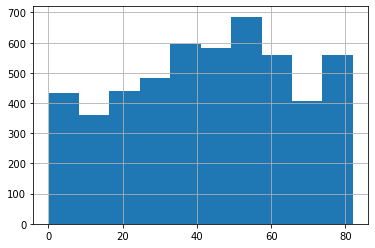

In [355]:
data.age.hist()

In [356]:
data.hypertension.value_counts(dropna=False)

0    4612
1     498
Name: hypertension, dtype: int64

In [357]:
data.heart_disease.value_counts(dropna=False)

0    4834
1     276
Name: heart_disease, dtype: int64

In [358]:
data.ever_married.value_counts(dropna=False)

Yes    3353
No     1757
Name: ever_married, dtype: int64

In [359]:
data.work_type.value_counts(dropna=False)

Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: work_type, dtype: int64

In [360]:
data.Residence_type.value_counts(dropna=False)

Urban    2596
Rural    2514
Name: Residence_type, dtype: int64

<AxesSubplot:>

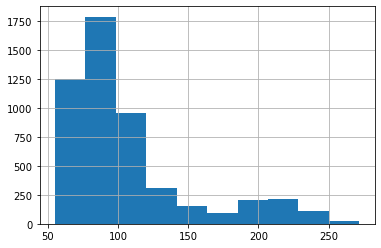

In [361]:
data.avg_glucose_level.hist()

<AxesSubplot:>

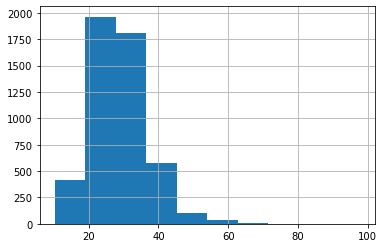

In [362]:
data.bmi.hist()

In [363]:
data.smoking_status.value_counts(dropna=False)

never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: smoking_status, dtype: int64

In [364]:
data.stroke.value_counts(dropna=False)

0    4861
1     249
Name: stroke, dtype: int64

### Data Preprocessing

In [365]:
data.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [366]:
numeric_features = ["age", "avg_glucose_level", "bmi"]

numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")),  
           ("scaler", StandardScaler())] #z-score
)

categorical_features = ["gender", "hypertension", "heart_disease", "ever_married", "work_type", "Residence_type", "smoking_status"]

categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)


### Model Training

In [367]:
clf = Pipeline(
    steps=[("preprocessor", preprocessor), 
           ("classifier", LogisticRegression())]
)

In [368]:
X = data.iloc[:, 1:-1]

In [369]:
y = data.iloc[:, -1]

In [370]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [371]:
clf.fit(X_train, y_train)
print("model score: %.3f" % clf.score(X_test, y_test))

model score: 0.948


### PCA

In [372]:
one_hot_encoder = OneHotEncoder(handle_unknown='ignore')

In [373]:
cat_col_df = data[categorical_features]

In [374]:
one_hot_encoder.fit(cat_col_df)

OneHotEncoder(handle_unknown='ignore')

In [375]:
one_hot_encoder.categories_

[array(['Female', 'Male', 'Other'], dtype=object),
 array([0, 1], dtype=int64),
 array([0, 1], dtype=int64),
 array(['No', 'Yes'], dtype=object),
 array(['Govt_job', 'Never_worked', 'Private', 'Self-employed', 'children'],
       dtype=object),
 array(['Rural', 'Urban'], dtype=object),
 array(['Unknown', 'formerly smoked', 'never smoked', 'smokes'],
       dtype=object)]

In [376]:
one_hot_df = pd.DataFrame(one_hot_encoder.transform(data[categorical_features]).toarray())

In [377]:
one_hot_df.shape

(5110, 20)

In [378]:
one_hot_df.columns=['Female', 'Male', 'Other', 'hypertension_0', 'hypertension_1', 'heart_disease_0', 'heart_disease_1', 'not_married', 'married', 'Govt_job',
                  'Never_worked', 'Private', 'Self-employed', 'children', 'Rural', 'Urban', 'Unknown', 'formerly_smoked', 'never_smoked', 'smokes']

In [379]:
one_hot_df

,Female,Male,Other,hypertension_0,hypertension_1,heart_disease_0,heart_disease_1,not_married,married,Govt_job,Never_worked,Private,Self-employed,children,Rural,Urban,Unknown,formerly_smoked,never_smoked,smokes
0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5105,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
5106,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
5107,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
5108,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [380]:
num_col_df = data[numeric_features]

In [381]:
num_col_df

,age,avg_glucose_level,bmi
0,67.0,228.69,36.6
1,61.0,202.21,NaN
2,80.0,105.92,32.5
3,49.0,171.23,34.4
4,79.0,174.12,24.0
...,...,...,...
5105,80.0,83.75,NaN
5106,81.0,125.20,40.0
5107,35.0,82.99,30.6
5108,51.0,166.29,25.6


In [382]:
scaler = StandardScaler()
median_imputer = SimpleImputer(strategy="median")
median_imputer.fit(num_col_df)
imputed_df = pd.DataFrame(median_imputer.transform(num_col_df))
scaler.fit(imputed_df)
scaler_df = pd.DataFrame(scaler.transform(imputed_df))

In [383]:
scaler_df.columns = ['age_std', 'avg_glucose_level_std', 'bmi_std']

In [384]:
full_data = one_hot_df.merge(scaler_df, left_index=True, right_index=True)

In [385]:
pca = PCA()
X_pca = pca.fit_transform(full_data)
total_explained_variance = pca.explained_variance_ratio_.cumsum()
n_over_95 = len(total_explained_variance[total_explained_variance >= .95])
n_to_reach_95 = X_pca.shape[1] - n_over_95 + 1

In [386]:
print("Number features: {0}, Total Variance Explained: {1}".format(n_to_reach_95, total_explained_variance[n_to_reach_95-1]))

Number features: 11, Total Variance Explained: 0.9526782238274881


In [387]:
X_pca = full_data

In [388]:
y_pca = data.iloc[:, -1]

In [389]:
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, y_pca, test_size=0.2, random_state=0)

In [390]:
pipe = Pipeline([('scaler', StandardScaler()),
                 ('pca', PCA(n_components=n_to_reach_95)),
                 ('clf', RandomForestClassifier())])

pipe.fit(X_train_pca,y_train_pca)

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=11)),
                ('clf', RandomForestClassifier())])

In [391]:
model = pipe.steps[1][1]
n_pcs= model.components_.shape[0]
initial_feature_names = X_train_pca.columns
most_important = [np.abs(model.components_[i]).argmax() for i in range(n_pcs)]

In [392]:
most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]

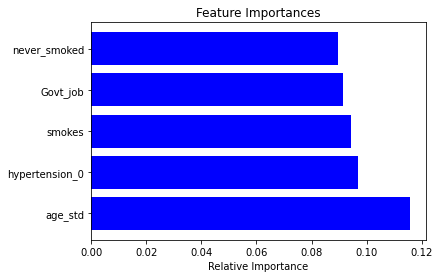

In [393]:
zipped_feats = zip(most_important_names, pipe.steps[2][1].feature_importances_)
zipped_feats = sorted(zipped_feats, key=lambda x: x[1], reverse=True)
features, importances = zip(*zipped_feats)
top_features = features[:5]
top_importances = importances[:5]
plt.title('Feature Importances')
plt.barh(range(len(top_importances)), top_importances, color='b', align='center')
plt.yticks(range(len(top_importances)), top_features)
plt.xlabel('Relative Importance')
plt.show()

In [394]:
print("model score: %.3f" % pipe.score(X_test_pca,y_test_pca))

model score: 0.945
